In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import numpy as np 
# import pandas as pd 
import matplotlib.pyplot as plt
# import geopandas as gpd
import sklearn, sklearn.cross_decomposition
from sklearn.cross_decomposition import CCA
sys.path.append('../src/')
sys.path.append('../content/')
import data_utils as du
import loadpaths
path_dict_pecl = loadpaths.loadpaths()
import analysis_utils as au

Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
Sentinel-2: 0 nans, 0 infs
AlphaEarth: 0 nans, 0 infs
Dynamic World: 0 nans, 0 infs


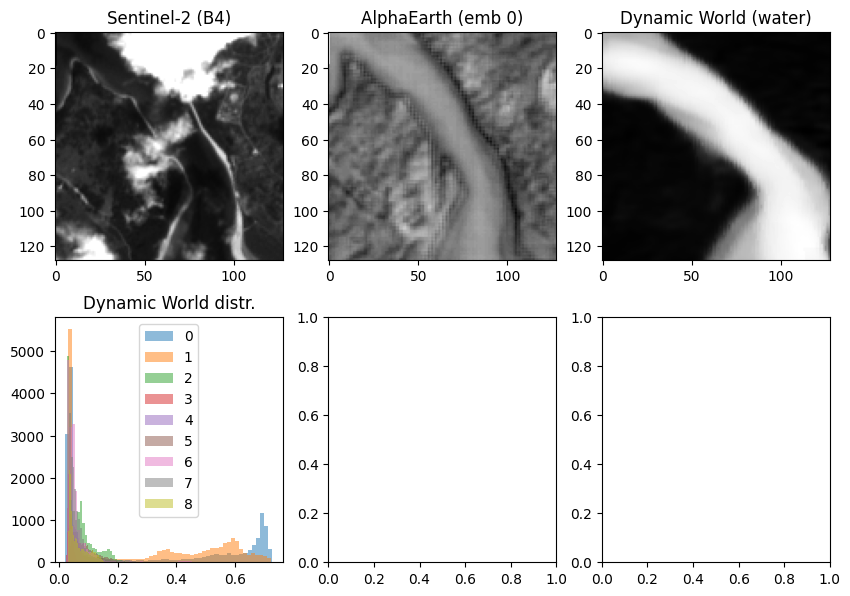

In [298]:
(data_sent, data_alpha, data_dyn, data_worldclim) = du.load_all_modalities_from_name(name='pecl-fig-0', path_folder='../content/sample_data', verbose=1)

## Check for number of nans, infs

data_alpha.values[np.isinf(data_alpha.values)] = 0

for arr, name in zip([data_sent, data_alpha, data_dyn], ['Sentinel-2', 'AlphaEarth', 'Dynamic World']):
    print(f"{name}: {np.sum(np.isnan(arr.values))} nans, {np.sum(np.isinf(arr.values))} infs")
    
fig, ax = plt.subplots(2,3, figsize=(10,7))
ax = ax.flatten()
ax[0].imshow(np.clip(data_sent[0, ...], 0, 3000) / 3000, cmap='gray')
ax[0].set_title('Sentinel-2 (B4)')
ax[1].imshow(data_alpha[0, ...], cmap='gray')
ax[1].set_title('AlphaEarth (emb 0)')
ax[2].imshow(data_dyn[0, ...], cmap='gray')
ax[2].set_title('Dynamic World (water)')

## plot distr DW:
for i_dw in range(data_dyn.shape[0]):
    ax[3].hist(data_dyn[i_dw, ...].values.flatten(), bins=50, alpha=0.5, label=i_dw)
ax[3].set_title('Dynamic World distr.')
ax[3].legend()

(64, 16384) (9, 16384)
[0.58661765 0.5873249  0.5929653  0.5956182  0.5968179  0.60670626
 0.6237366  0.6303861  0.64634985 0.6509705 ]


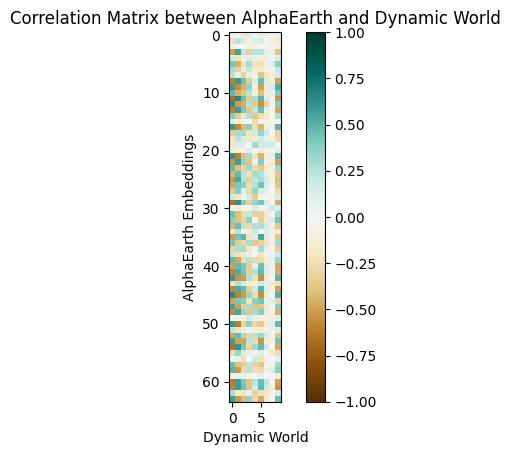

In [299]:
embed_mat = data_alpha.values.reshape(data_alpha.shape[0], -1)
dw_mat = data_dyn.values.reshape(data_dyn.shape[0], -1)
assert embed_mat.shape[1] == dw_mat.shape[1]

corr_mat = au.correlation_two_matrices(embed_mat, dw_mat)
plt.imshow(corr_mat, vmin=-1, vmax=1, cmap='BrBG')
plt.colorbar()
plt.xlabel('Dynamic World')
plt.ylabel('AlphaEarth Embeddings')
plt.title('Correlation Matrix between AlphaEarth and Dynamic World')

print(np.sort(corr_mat.flatten())[-10:])

Corr embd 3 vs dw 1: 0.5486385822296143


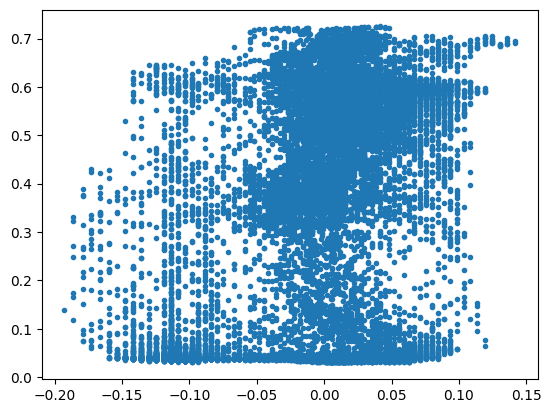

In [300]:
ind_embd = 3
ind_dw = 1
print(f"Corr embd {ind_embd} vs dw {ind_dw}: {corr_mat[ind_embd, ind_dw]}")

plt.plot(embed_mat[ind_embd, :], dw_mat[ind_dw, :], '.')
# print(np.corrcoef(embed_mat[ind_embd, :], dw_mat[ind_dw, :]))

# CCA

In [301]:
cca = CCA(n_components=6)
X_c, Y_c = cca.fit_transform(embed_mat.T, dw_mat.T)
# print(X_c.shape, Y_c.shape)
corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)]
print("Canonical correlations:", np.round(corrs, 3))

Canonical correlations: [0.912 0.792 0.685 0.633 0.596 0.551]


(6, 16384) (6, 16384)


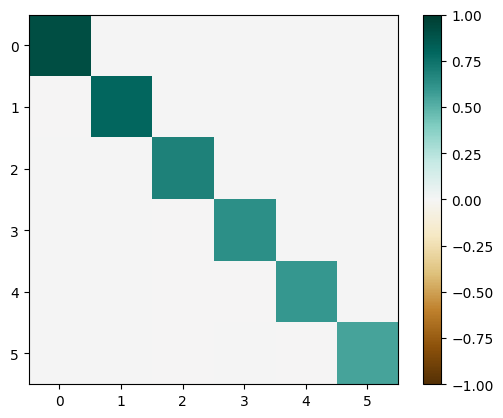

In [302]:

plt.imshow(au.correlation_two_matrices(X_c.T, Y_c.T), vmin=-1, vmax=1, cmap='BrBG')
plt.colorbar()

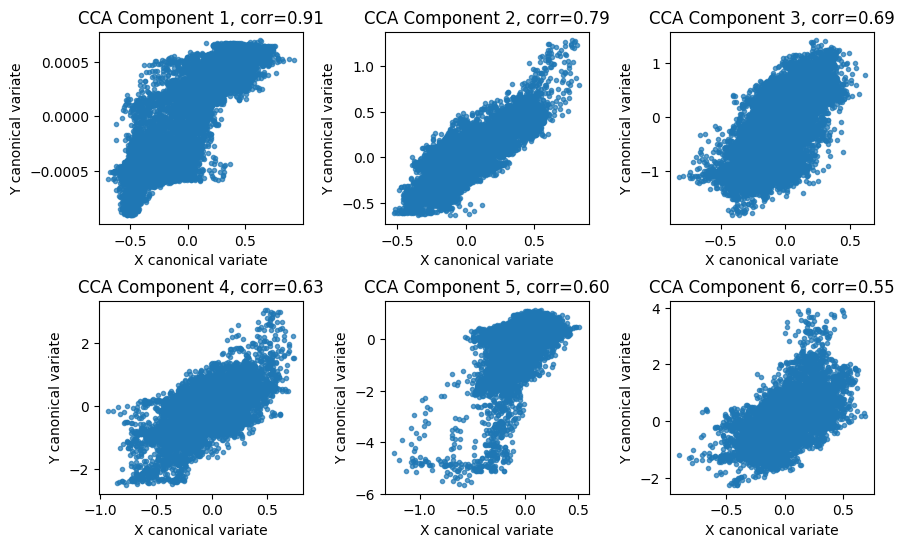

In [303]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6), gridspec_kw={'hspace': 0.4, 'wspace': 0.4})
ax = ax.flatten()
for ii in range(cca.n_components):
    ax[ii].plot(X_c[:, ii], Y_c[:, ii], '.', label=f'Component {ii + 1} (corr={corrs[ii]:.2f})', alpha=0.7)
    ax[ii].set_xlabel('X canonical variate')
    ax[ii].set_ylabel('Y canonical variate')
    ax[ii].set_title(f'CCA Component {ii + 1}, corr={corrs[ii]:.2f}')
# plt.xlabel("X canonical variate")
# plt.ylabel("Y canonical variate")
# plt.legend()
# plt.title("Canonical Correlation Analysis (CCA)")
# plt.show()

x_weights: (64, 6)
Min, max: -0.3628656760139933, 0.4474708491608703
y_weights: (9, 6)
Min, max: -0.7249009000630422, 0.7322184608205521
x_loadings: (64, 6)
Min, max: -2.4112131735290157, 2.955918278577385
y_loadings: (9, 6)
Min, max: -1961.5042809569395, 1930.7394478117365


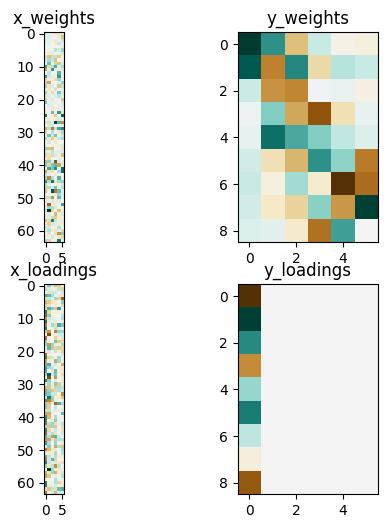

In [304]:
dict_outcome_cca = {
    'x_weights': cca.x_weights_,
    'y_weights': cca.y_weights_,
    'x_loadings': cca.x_loadings_,
    'y_loadings': cca.y_loadings_
}

fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax = ax.flatten()
for ii, (key, val) in enumerate(dict_outcome_cca.items()):
    print(f"{key}: {val.shape}")
    print(f'Min, max: {np.min(val)}, {np.max(val)}')
    im = ax[ii].imshow(val, cmap='BrBG', vmin=-np.max(np.abs(val)), vmax=np.max(np.abs(val)))
    ax[ii].set_title(key)

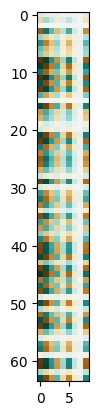

In [305]:
plt.imshow(np.dot(dict_outcome_cca['x_loadings'], dict_outcome_cca['y_loadings'].T), cmap='BrBG')

In [306]:
X = embed_mat.T
Y = dw_mat.T
canonical_corrs = np.array([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)])
print("Canonical correlations:", canonical_corrs)

# --- 4. Compute Redundancy Index ---
# Correlations of original variables with canonical variates
corr_X_U = np.corrcoef(X.T, X_c.T)[0:X.shape[1], X.shape[1]:]
corr_Y_V = np.corrcoef(Y.T, Y_c.T)[0:Y.shape[1], Y.shape[1]:]

# Variance explained by each canonical variate in X and Y
var_expl_X = np.mean(corr_X_U**2, axis=0)
var_expl_Y = np.mean(corr_Y_V**2, axis=0)

# Redundancy per component
redundancy_X = canonical_corrs**2 * var_expl_X
redundancy_Y = canonical_corrs**2 * var_expl_Y

print("Variance explained in X per component:", var_expl_X)
print("Variance explained in Y per component:", var_expl_Y)
print("Redundancy (variance explained) in X:", redundancy_X)
print("Redundancy (variance explained) in Y:", redundancy_Y)


Canonical correlations: [0.91230319 0.79209658 0.68513466 0.63252035 0.59596107 0.5510786 ]
Variance explained in X per component: [0.27473728 0.04363567 0.01255246 0.03665172 0.00930009 0.0166199 ]
Variance explained in Y per component: [0.36373821 0.07664161 0.1911924  0.06349088 0.11465745 0.08588596]
Redundancy (variance explained) in X: [0.22866305 0.02737776 0.00589224 0.01466369 0.00330311 0.00504726]
Redundancy (variance explained) in Y: [0.30273826 0.04808625 0.08974753 0.02540156 0.04072284 0.0260825 ]


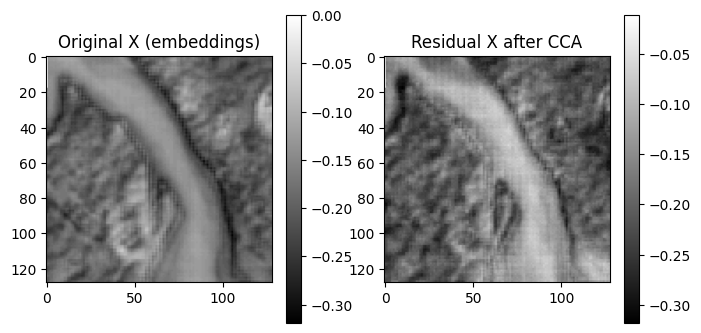

In [307]:
X_hat = X_c @ cca.x_weights_.T
X_residual = X - X_hat

orig_dim = 128 
assert orig_dim ** 2 == X.shape[0]
X_residual_img = X_residual.T.reshape(-1, orig_dim, orig_dim)
X_img = X.T.reshape(-1, orig_dim, orig_dim)


ind_plot = 0

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(X_img[ind_plot, ...], cmap='gray')
ax[0].set_title('Original X (embeddings)')
# colorbar
fig.colorbar(ax[0].imshow(X_img[ind_plot, ...], cmap='gray'), ax=ax[0])
ax[1].imshow(X_residual_img[ind_plot, ...], cmap='gray')
ax[1].set_title('Residual X after CCA')
# colorbar
fig.colorbar(ax[1].imshow(X_residual_img[ind_plot, ...], cmap='gray'), ax=ax[1])
plt.show()


(64, 16384) (9, 16384)
(64, 16384) (9, 16384)


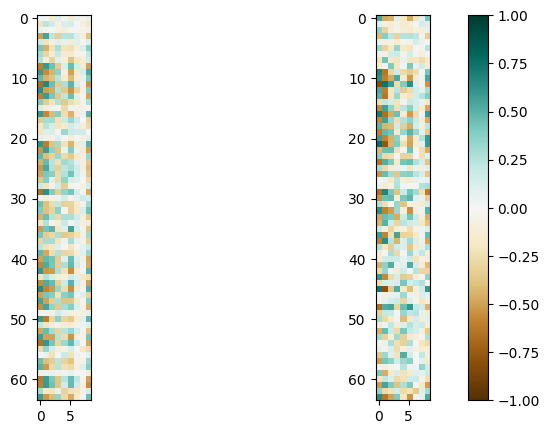

In [308]:
embed_mat = data_alpha.values.reshape(data_alpha.shape[0], -1)
dw_mat = data_dyn.values.reshape(data_dyn.shape[0], -1)
assert embed_mat.shape[1] == dw_mat.shape[1]

corr_mat = au.correlation_two_matrices(embed_mat, dw_mat)

fig, ax = plt.subplots(1,2, figsize=(10,5))
im = ax[0].imshow(corr_mat, vmin=-1, vmax=1, cmap='BrBG')
# fig.colorbar(im, ax=ax)

im = ax[1].imshow(au.correlation_two_matrices(X_residual.T, dw_mat), vmin=-1, vmax=1, cmap='BrBG')
fig.colorbar(im, ax=ax)

# CCA Multi

In [67]:

# Then collect from all patches the alpha and dyn data
patches = 200
hypotheses = []
features = []
sentinel = []
for p in range(patches):
    # (data_sent, data_alpha, data_dyn, data_worldclim, data_dsm) = du.load_all_modalities_from_name(name=f'pecl-fig-{p}', path_folder='../content/sample_data', verbose=1)
    (data_sent, data_alpha, data_dyn, data_worldclim, data_dsm) = du.load_all_modalities_from_name(name=f'pecl176-{p}', 
                                                                        path_folder='/Users/tplas/data/2025-10 neureo/pecl-100-subsample-30km', verbose=0)
    
    if data_sent is None:
        continue
    # Land coverage and DSM serve as hypotheses
    hypotheses.append(np.concatenate([data_dyn.data, data_dsm.data], axis=0))
    # hypotheses.append(data_dyn.data)
    # This can definitely be cleaner but I use nan for undefined values
    f_dat = data_alpha.data
    f_dat[~np.isfinite(f_dat)] = np.nan
    f_dat[np.isnan(f_dat)] = 0
    # f_dat[np.logical_and(f_dat < 0.05, f_dat > -0.05)] = 0  # Thresholding to remove noise

    features.append(f_dat)    
    sentinel.append(data_sent.data)

features_all = np.stack(features, axis=0)
features_all = au.ravel_features(features_all)
features_all = features_all[:, np.isnan(features_all).sum(0) == 0]

n_patches = len(features)
n_hyp = hypotheses[0].shape[0]
n_feat = features[0].shape[0]
print(f"Number of patches: {n_patches}, number of hypotheses: {n_hyp}, number of features: {n_feat}")
    
# ## zscore hypotheses:
# hyp_stack = au.ravel_features(np.stack(hypotheses))
# means = np.mean(hyp_stack, axis=1)
# std = np.std(hyp_stack, axis=1)
# hyp_stack_z = (hyp_stack - means[:, np.newaxis]) / (std[:, np.newaxis] + 1e-6)
# hyp_stack_z = au.unravel_features(hyp_stack_z, n_patches=n_patches, nx=128, ny=128)
# hyp_z = [hyp_stack_z[i, ...] for i in range(n_patches)]
# hypotheses = hyp_z


# ## zscore features:
# feat_stack = au.ravel_features(np.stack(features))
# means = np.mean(feat_stack, axis=1)
# std = np.std(feat_stack, axis=1)
# feat_stack_z = (feat_stack - means[:, np.newaxis]) / (std[:, np.newaxis] + 1e-6)
# feat_stack_z = au.unravel_features(feat_stack_z, n_patches=n_patches, nx=128, ny=128)
# feat_z = [feat_stack_z[i, ...] for i in range(n_patches)]
# features = feat_z


Number of patches: 100, number of hypotheses: 10, number of features: 64


In [68]:
X = au.ravel_features(np.stack(features))
Y = au.ravel_features(np.stack(hypotheses))
assert X.shape[1] == Y.shape[1], (X.shape, Y.shape)

cca = CCA(n_components=10)
X_c, Y_c = cca.fit_transform(X.T, Y.T)
# print(X_c.shape, Y_c.shape)
corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)]
print("Canonical correlations:", np.round(corrs, 3))


Canonical correlations: [0.917 0.851 0.751 0.731 0.664 0.637 0.562 0.52  0.487 0.153]


In [69]:

X_hat = X_c @ cca.x_weights_.T
X_residual = X - X_hat.T
X_residual_img = au.unravel_features(X_residual, n_patches=n_patches, nx=128, ny=128)
X_hat_img = au.unravel_features(X_hat.T, n_patches=n_patches, nx=128, ny=128)

print(X.shape, X_hat_img.shape, X_residual_img.shape)

(64, 1638400) (100, 64, 128, 128) (100, 64, 128, 128)


In [70]:
mat_var_greater = np.zeros((n_patches, n_feat))
for ip in range(n_patches):
    for i_f in range(n_feat):
        mat_var_greater[ip, i_f] = np.var(features[ip][i_f]) - np.var(X_residual_img[ip][i_f])

np.where(mat_var_greater == np.min(mat_var_greater))

(array([15]), array([42]))

In [71]:
mat_reconstruction_loss = np.array([np.sum(np.abs(f - X_hat_img[ii, ...]), (1, 2)) for ii, f in enumerate(features)]).sum(0)
print(mat_reconstruction_loss.shape)
np.where(mat_reconstruction_loss == np.min(mat_reconstruction_loss))

(64,)


(array([20]),)

In [72]:
np.abs(features[0][i_f] - 1 * X_hat_img[0][i_f]).sum()

np.float64(1054.7509394888361)

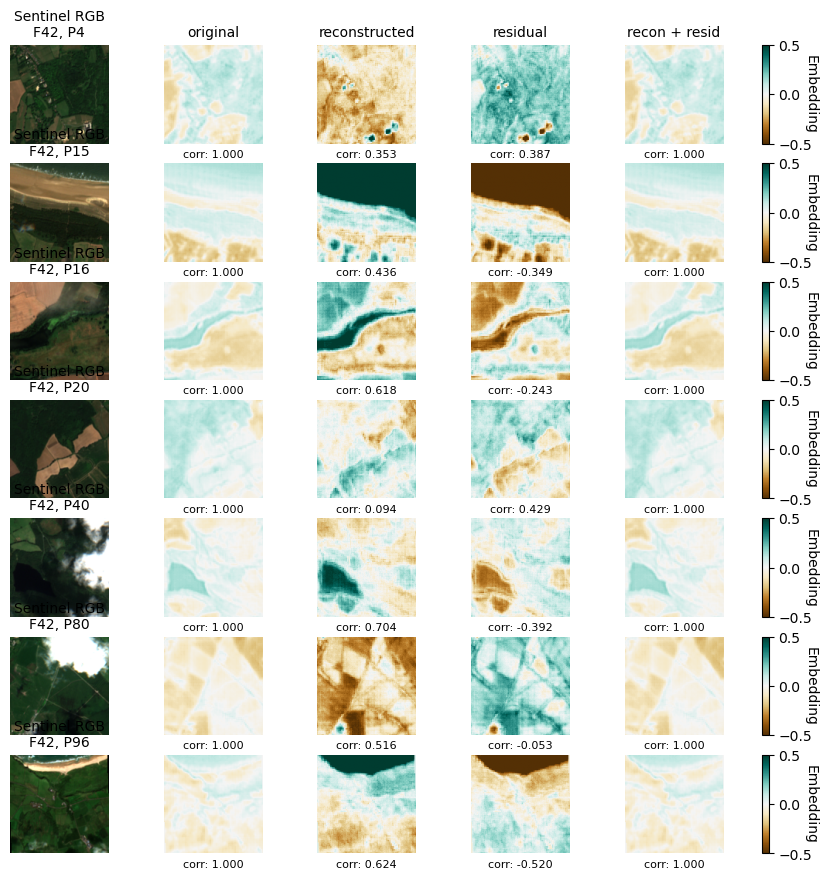

In [73]:
list_patch_inds = [4, 15, 16, 20, 40, 80, 96]
i_f = 42

fig, all_ax = plt.subplots(len(list_patch_inds), 6, figsize=(10, 1.5 * len(list_patch_inds)), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0.05]})


for i_row, i_patch_example in enumerate(list_patch_inds):
    ax = all_ax[i_row, :]
    for ax_ in ax:
        du.naked(ax_)

    ax[0].imshow(np.clip(np.swapaxes(np.swapaxes(sentinel[i_patch_example][:3], 0, 2), 0, 1), 0, 3000) / 3000)
    ax[0].set_title(f'Sentinel RGB\nF{i_f}, P{i_patch_example}', fontsize=10)

    lim = np.nanmax(np.abs(np.stack(features, axis=-1)[i_f, ...]))
    lim = max(lim, 0.5)
    for ii, (name, im_plot) in enumerate(zip(['original', 'reconstructed', 'residual', 'recon + resid'], [features, X_hat_img, X_residual_img, X_hat_img + X_residual_img])):
        ax[ii + 1].imshow(im_plot[i_patch_example][i_f], vmin=-lim, vmax=lim, cmap='BrBG')
        corr_with_orig_feat = np.corrcoef(im_plot[i_patch_example][i_f].flatten(), features[i_patch_example][i_f].flatten())[0, 1]
        ax[ii + 1].set_xlabel(f'corr: {corr_with_orig_feat:.3f}', fontsize=8)
        if i_row == 0:
            ax[ii + 1].set_title(name, fontsize=10)

    cbar = plt.colorbar(mappable=ax[1].images[0], ax=ax[1], #fraction=0.046, pad=0.04, 
                        cax=ax[5])
    ax[5].set_ylabel('Embedding', rotation=270)
    # ax[0].text(s='1.28 km wide', x=-20, y=128, ha='left', va='bottom', 
    #                     clip_on=False, rotation=90)



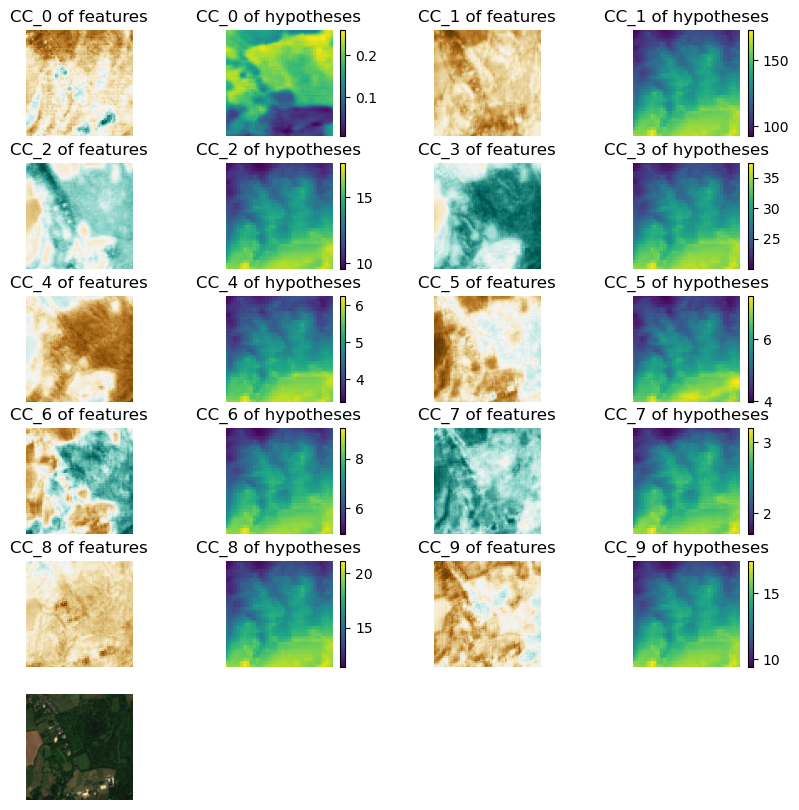

In [77]:
# ind_cc = 1
# ind_patch += 1
ind_patch = 4

fig, ax = plt.subplots(cca.n_components // 2 + 1, 4, figsize=(10, 10), 
                       gridspec_kw={'hspace': 0.25, 'wspace': 0.25})
ax = ax.ravel()
ii = 0
cc_x = np.dot(cca.x_weights_.T, features[ind_patch].reshape(n_feat, -1)).reshape(cca.n_components, 128, 128) 
cc_y = np.dot(cca.y_weights_.T, hypotheses[ind_patch].reshape(n_hyp, -1)).reshape(cca.n_components,128, 128) 
# feat_lim = np.max(np.abs(cc_x))
# hyp_lim = np.max(np.abs(cc_y))
      
for ind_cc in range(cca.n_components):
    curr_ax_feat = ax[ii]
    curr_ax_hyp = ax[ii + 1]

    feat_lim = np.max(np.abs(cc_x[ind_cc]))
    hyp_lim = np.max(np.abs(cc_y[ind_cc]))

    curr_ax_feat.imshow(cc_x[ind_cc], cmap='BrBG_r', vmin=-feat_lim, vmax=feat_lim)
    # ax[0].imshow(X_hat_img[0, 1, :, :], cmap='gray')
    # ax[1].imshow(features[0][1, ...], cmap='gray')
    # curr_ax_hyp.imshow(cc_y[ind_cc], cmap='RdBu_r', vmin=-hyp_lim, vmax=hyp_lim)
    im = curr_ax_hyp.imshow(np.abs(cc_y[ind_cc]), cmap='viridis')
    plt.colorbar(im, ax=curr_ax_hyp)
    curr_ax_feat.set_title(f'CC_{ind_cc} of features')
    curr_ax_hyp.set_title(f'CC_{ind_cc} of hypotheses')

    ii += 2

ax[ii].imshow(np.clip(np.swapaxes(np.swapaxes(sentinel[ind_patch][:3], 0, 2), 0, 1), 0, 3000) / 3000)

for a in ax:
    a.axis('off')

feat_weights: (64, 10)
Min, max: -0.3424903717637051, 0.39802538532803494
hyp_weights: (10, 10)
Min, max: -0.9580946315892529, 0.749819258826361
feat_loadings: (64, 10)
Min, max: -1.2900398985808983, 1.0225144743201449
hyp_loadings: (10, 10)
Min, max: -411.9437918455271, 258.5248280883105


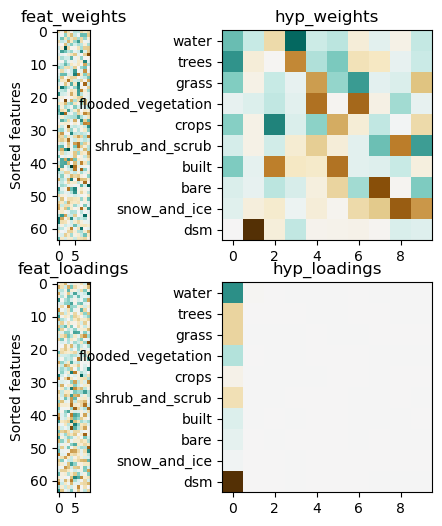

In [75]:
dict_outcome_cca = {
    'feat_weights': cca.x_weights_,
    'hyp_weights': cca.y_weights_,
    'feat_loadings': cca.x_loadings_,
    'hyp_loadings': cca.y_loadings_
}
hyp_names = du.get_hyp_names()
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax = ax.flatten()
for ii, (key, val) in enumerate(dict_outcome_cca.items()):
    print(f"{key}: {val.shape}")
    print(f'Min, max: {np.min(val)}, {np.max(val)}')
    im = ax[ii].imshow(val, cmap='BrBG', vmin=-np.max(np.abs(val)), vmax=np.max(np.abs(val)))
    ax[ii].set_title(key)
    if key[:3] == 'hyp':
        ax[ii].set_yticks(np.arange(n_hyp))
        ax[ii].set_yticklabels(hyp_names)
    else:
        ax[ii].set_ylabel('Sorted features')

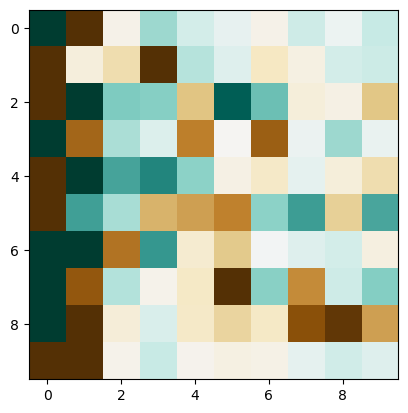

In [11]:
plt.imshow(dict_outcome_cca['hyp_loadings'][:, :], vmax=1, vmin=-1, cmap='BrBG')

In [212]:
canonical_corrs = np.array([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(cca.n_components)])
print("Canonical correlations:", canonical_corrs)

# Correlations of original variables with canonical variates
corr_X_U = np.corrcoef(X, X_c.T)[0:X.shape[0], X.shape[0]:]
corr_Y_V = np.corrcoef(Y, Y_c.T)[0:Y.shape[0], Y.shape[0]:]

# Variance explained by each canonical variate in X and Y
var_expl_X = np.mean(corr_X_U**2, axis=0)
var_expl_Y = np.mean(corr_Y_V**2, axis=0)

# Redundancy per component
redundancy_X = canonical_corrs**2 * var_expl_X
redundancy_Y = canonical_corrs**2 * var_expl_Y

print("Variance explained in X per component:", var_expl_X)
print("Variance explained in Y per component:", var_expl_Y)
print("Redundancy (variance explained) in X:", redundancy_X)
print("Redundancy (variance explained) in Y:", redundancy_Y)

Canonical correlations: [0.91712035 0.85079058 0.75080918 0.73094219 0.66356402 0.63697692
 0.56213168 0.52048989 0.4865634  0.15345909]
Variance explained in X per component: [0.08570172 0.12310632 0.08641325 0.08277522 0.04819185 0.05216568
 0.02862828 0.01784466 0.01689129 0.02705275]
Variance explained in Y per component: [0.14873614 0.11927967 0.15990923 0.13713734 0.12231087 0.11441062
 0.07386875 0.06305633 0.06017343 0.00111761]
Redundancy (variance explained) in X: [0.07208455 0.08910984 0.04871239 0.04422485 0.0212197  0.02116568
 0.00904631 0.00483429 0.00399891 0.00063708]
Redundancy (variance explained) in Y: [1.25103415e-01 8.63399442e-02 9.01431378e-02 7.32692572e-02
 5.38555831e-02 4.64209193e-02 2.33419358e-02 1.70825742e-02
 1.42456962e-02 2.63194110e-05]


In [81]:
X_img = au.unravel_features(X, n_patches=n_patches, nx=128, ny=128)

100%|██████████| 20/20 [00:09<00:00,  2.08it/s]


Text(0.5, 1.0, 'Dim residual (H)')

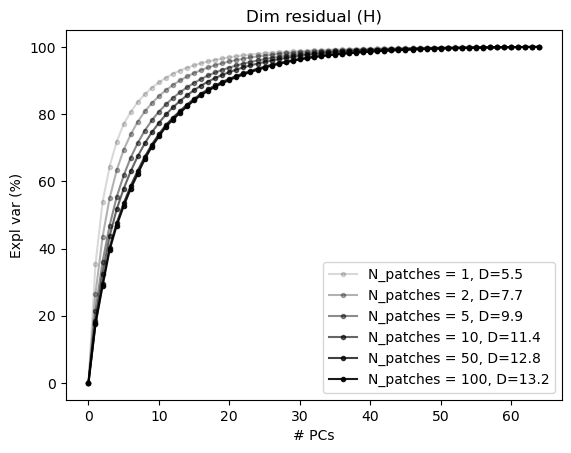

In [203]:
from tqdm import tqdm

# features_pca = X_residual_img
features_pca = X_res_fit

n_feat = 64
list_n = [1, 2, 5, 10, 50, 100]
n_samples = 20
dict_expl_var, dict_dim = {n: np.zeros((n_samples, n_feat)) for n in list_n}, {}

for n in list_n:
    dim_list = []
    for i in tqdm(range(n_samples)):
        # Randomly sample n features
        inds = np.random.choice(a=features_pca.shape[0], size=n, replace=False)
        features_sampled = features_pca[inds, ...]
        features_sampled = au.ravel_features(features_sampled)
        features_sampled[np.isnan(features_sampled)] = 0

        # PCA
        pca = sklearn.decomposition.PCA(n_components=64)
        pca.fit(features_sampled.T)

        cum_expl_var = np.cumsum(pca.explained_variance_ratio_)
        dict_expl_var[n][i, :] = cum_expl_var

        sum_squares = np.sum(np.power(pca.explained_variance_, 2))
        square_sum = np.sum(pca.explained_variance_) ** 2
        dim = float(square_sum / sum_squares)
        # print(dim)
        dim_list.append(dim)
    dict_dim[n] = dim_list

for i_n, n in enumerate(dict_expl_var.keys()):
    plt.plot(np.concatenate([[0], dict_expl_var[n].mean(0)]) * 100, '.-', c='k', alpha=(i_n + 1) * 0.15,
             label=f'N_patches = {n}, D={np.round(np.mean(dict_dim[n]), 1)}')

# plt.xscale('log')
plt.legend()
plt.xlabel('# PCs')
plt.ylabel('Expl var (%)')
plt.title('Dim residual (H)')


In [186]:
X.shape, au.ravel_features(X_hat_fit).shape, X_hat.shape

((64, 1638400), (64, 1638400), (1638400, 64))

Text(0, 0.5, 'Var reconstructed features')

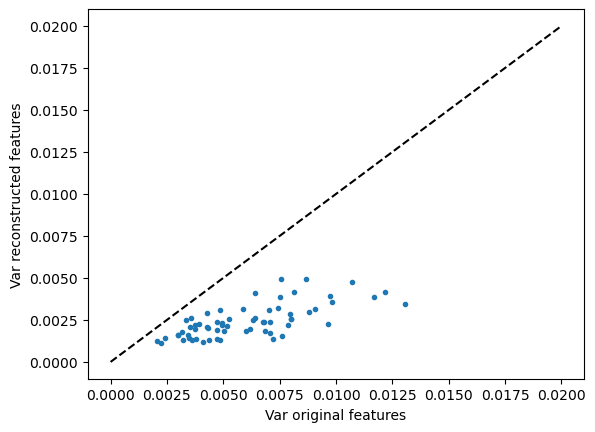

In [189]:
plt.plot([0, 0.02], [0, 0.02], 'k--')
plt.plot(np.var(X, 1), np.var(au.ravel_features(X_res_fit), 1), '.')
plt.xlabel('Var original features')
plt.ylabel('Var reconstructed features')

<Axes: xlabel='variance', ylabel='entropy'>

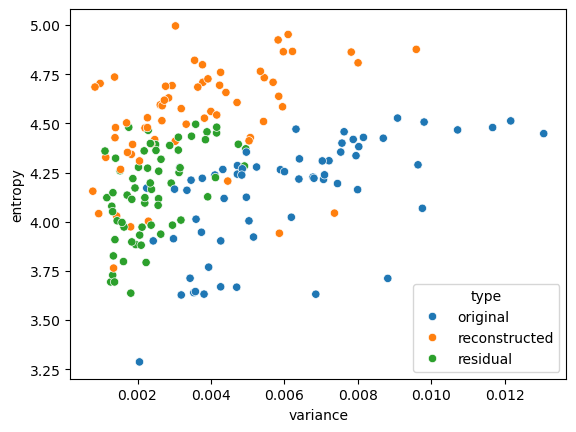

In [190]:
# lim = 0.5#min(0.5, max(np.max(X), np.max(X_residual)))
dict_metrics = {x: [] for x in ['feature', 'type', 'variance', 'entropy']}
for i_f in range(n_feat):
    # for name_data, activity in zip(['original', 'reconstructed', 'residual'], [X, X_hat.T, X_residual]):
    for name_data, activity in zip(['original', 'reconstructed', 'residual'], [X, au.ravel_features(X_hat_fit), au.ravel_features(X_res_fit)]):
        activity = np.squeeze(activity[i_f, :])
        lim = np.max(np.abs(activity))
        var = np.var(activity)
        hist, bin_edges = np.histogram(activity, bins=200, range=(-lim, lim), density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        hist = hist / np.sum(hist)
        entropy = -np.sum(hist * np.log(hist + 1e-10))
        dict_metrics['feature'].append(i_f)
        dict_metrics['type'].append(name_data)
        dict_metrics['variance'].append(var)
        dict_metrics['entropy'].append(entropy)
        # plt.plot(bin_centers, hist, label=f'F{i_f}, H={entropy:.2f}, Var={var:.4f}')
        # if i_f >= 5:
        #     break
# plt.legend()
import pandas as pd
import seaborn as sns
df_metrics = pd.DataFrame(dict_metrics)

sns.scatterplot(data=df_metrics, x='variance', y='entropy', hue='type')

Text(0.5, 1.0, 'entropy comparison')

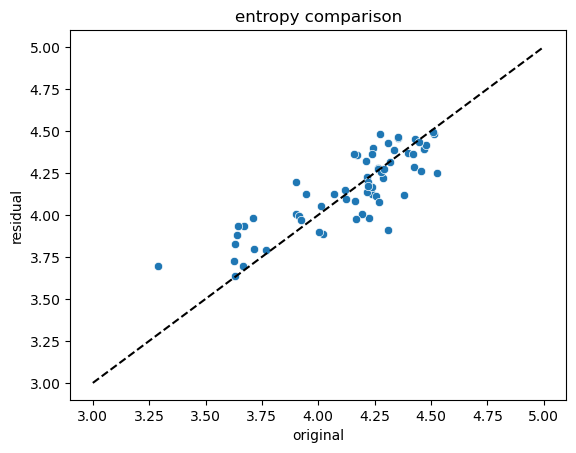

In [195]:
plt.plot([3, 5], [3, 5], 'k--')
sns.scatterplot(data=pd.pivot_table(df_metrics, index='feature', columns='type', values='entropy'), x='original', y='residual')
plt.title('entropy comparison')

In [140]:
dict_fit = {x: [] for x in ['factor', 'l1', 'l2']}
for fact in tqdm(np.arange(0, 1, 0.1)):
    loss = np.abs(X - fact * X_hat.T)
    dict_fit['factor'].append(fact)
    dict_fit['l1'].append(np.sum(loss))
    dict_fit['l2'].append(np.sum(np.power(loss, 2)))



100%|██████████| 10/10 [00:09<00:00,  1.03it/s]


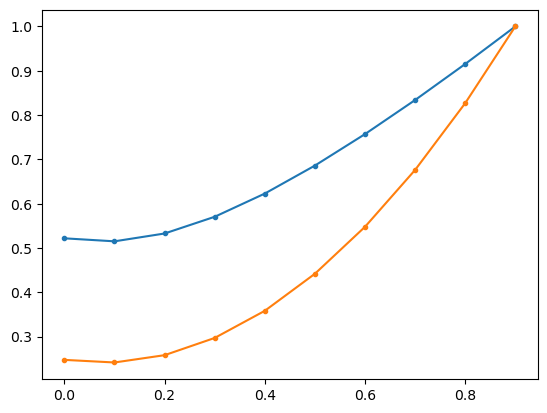

In [141]:
plt.plot(dict_fit['factor'], dict_fit['l1'] / np.max(dict_fit['l1']), '.-')
plt.plot(dict_fit['factor'], dict_fit['l2'] / np.max(dict_fit['l2']), '.-')

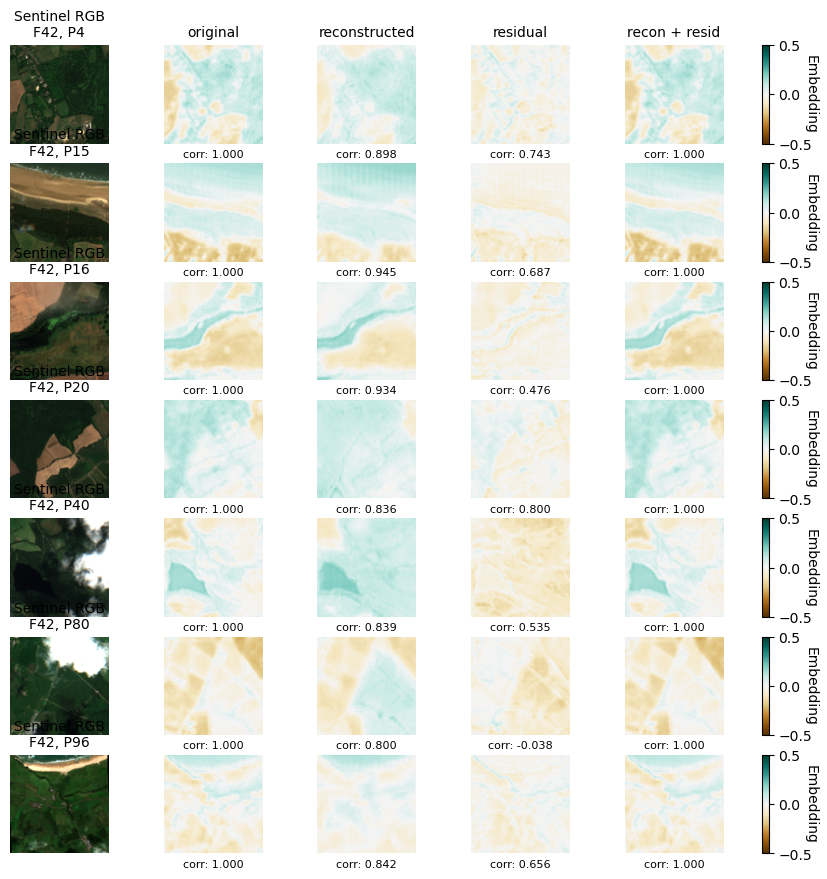

In [212]:
list_patch_inds = [4, 15, 16, 20, 40, 80, 96]
i_f = 42

fig, all_ax = plt.subplots(len(list_patch_inds), 6, figsize=(10, 1.5 * len(list_patch_inds)), 
                           gridspec_kw={'width_ratios': [1, 1, 1, 1, 1, 0.05]})

A = cca.x_weights_.T
U = X_c
# U = au.ravel_features(np.stack(hypotheses)).T
## Original:
## X = U @ A.T + residuals
## OLS alternative:
## X = U @ pinv(U) @ X + residuals
B = np.linalg.pinv(U).dot(X.T)
assert A.shape == B.shape, (A.shape, B.shape)
assert A.shape == (cca.n_components, n_feat)
X_hat_fit = U.dot(B).T
# U.dot(np.linalg.pinv(U).dot(X.T)).T

X_hat_fit = au.unravel_features(X_hat_fit, n_patches=n_patches, nx=128, ny=128)

# fact_best = 0.5
# scaled_X_hat = fact_best * X_hat_img
X_res_fit = np.stack(features) - X_hat_fit
for i_row, i_patch_example in enumerate(list_patch_inds):
    ax = all_ax[i_row, :]
    for ax_ in ax:
        du.naked(ax_)

    ax[0].imshow(np.clip(np.swapaxes(np.swapaxes(sentinel[i_patch_example][:3], 0, 2), 0, 1), 0, 3000) / 3000)
    ax[0].set_title(f'Sentinel RGB\nF{i_f}, P{i_patch_example}', fontsize=10)

    lim = np.nanmax(np.abs(np.stack(features, axis=-1)[i_f, ...]))
    lim = max(lim, 0.5)
    for ii, (name, im_plot) in enumerate(zip(['original', 'reconstructed', 'residual', 'recon + resid'], [features, X_hat_fit, X_res_fit, X_hat_fit + X_res_fit])):
        ax[ii + 1].imshow(im_plot[i_patch_example][i_f], vmin=-lim, vmax=lim, cmap='BrBG')
        corr_with_orig_feat = np.corrcoef(im_plot[i_patch_example][i_f].flatten(), features[i_patch_example][i_f].flatten())[0, 1]
        ax[ii + 1].set_xlabel(f'corr: {corr_with_orig_feat:.3f}', fontsize=8)
        if i_row == 0:
            ax[ii + 1].set_title(name, fontsize=10)

    cbar = plt.colorbar(mappable=ax[1].images[0], ax=ax[1], #fraction=0.046, pad=0.04, 
                        cax=ax[5])
    ax[5].set_ylabel('Embedding', rotation=270)
    # ax[0].text(s='1.28 km wide', x=-20, y=128, ha='left', va='bottom', 
    #                     clip_on=False, rotation=90)



In [217]:
dict_corr_with_feat = { 'patch': [], 'feature': [], 'type': [], 'corr_with_orig': [] }

for i_row, i_patch_example in tqdm(enumerate(list_patch_inds)):
    for i_f in range(42, 43):
        for ii, (name, im_plot) in enumerate(zip(['reconstructed', 'residual', 'recon + resid'], [X_hat_fit, X_res_fit, X_hat_fit + X_res_fit])):
            corr_with_orig_feat = np.corrcoef(im_plot[i_patch_example][i_f].flatten(), features[i_patch_example][i_f].flatten())[0, 1]
            dict_corr_with_feat['patch'].append(i_patch_example)
            dict_corr_with_feat['feature'].append(i_f)
            dict_corr_with_feat['type'].append(name)
            dict_corr_with_feat['corr_with_orig'].append(corr_with_orig_feat)
        

7it [00:01,  5.38it/s]


In [ ]:
features_stacked = np.stack(features)
## ravel last 2 dims:
features_collapsed = features_stacked.reshape(features_stacked.shape[0], features_stacked.shape[1], -1)
X_hat_fit_collapsed = X_hat_fit.reshape(X_hat_fit.shape[0], X_hat_fit.shape[1], -1)
X_res_fit_collapsed = X_res_fit.reshape(X_res_fit.shape[0], X_res_fit.shape[1], -1)

## ravel first 2 dims:
features_collapsed = features_collapsed.reshape(-1, features_collapsed.shape[2])
X_hat_fit_collapsed = X_hat_fit_collapsed.reshape(-1, X_hat_fit_collapsed.shape[2])
X_res_fit_collapsed = X_res_fit_collapsed.reshape(-1, X_res_fit_collapsed.shape[2])


assert features_collapsed.shape == X_hat_fit_collapsed.shape == X_res_fit_collapsed.shape, (features_collapsed.shape, X_hat_fit_collapsed.shape, X_res_fit_collapsed.shape)
assert features_collapsed.shape[0] == n_patches * n_feat


In [240]:
corrs_recon = []
corrs_res = []

for ii in range(features_collapsed.shape[0]):
    corrs_recon.append(np.corrcoef(features_collapsed[ii, :], X_hat_fit_collapsed[ii, :])[0, 1])
    corrs_res.append(np.corrcoef(features_collapsed[ii, :], X_res_fit_collapsed[ii, :])[0, 1])

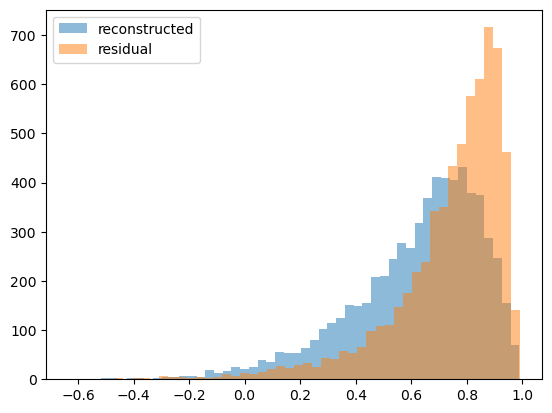

In [242]:
plt.hist(corrs_recon, bins=50, alpha=0.5, label='reconstructed')
plt.hist(corrs_res, bins=50, alpha=0.5, label='residual')
plt.legend();

In [200]:
# U.shape
au.ravel_features(np.stack(hypotheses)).shape, U.shape

((10, 1638400), (1638400, 10))

Text(0.5, 1.0, 'OLS weights (features)')

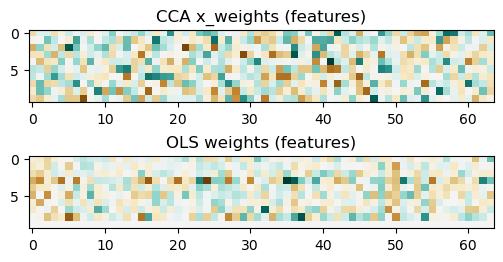

In [204]:
fig, ax = plt.subplots(2, 1, figsize=(6, 3))

ax[0].imshow(A, cmap='BrBG', vmin=-np.max(np.abs(A)), vmax=np.max(np.abs(A)))
ax[0].set_title('CCA x_weights (features)')

ax[1].imshow(B, cmap='BrBG', vmin=-np.max(np.abs(B)), vmax=np.max(np.abs(B)))
ax[1].set_title('OLS weights (features)')

Text(0, 0.5, 'OLS weights')

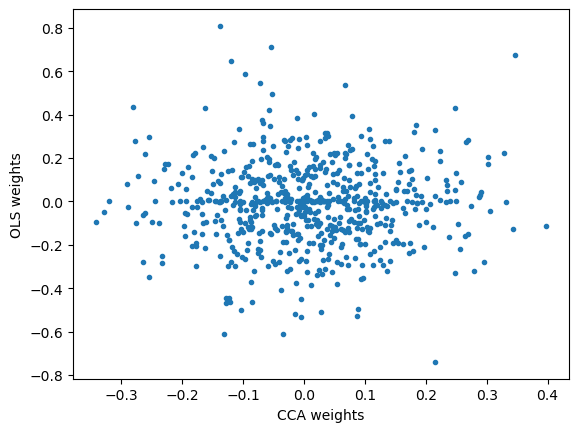

In [205]:
plt.plot(A.flatten(), B.flatten(), '.')
plt.xlabel('CCA weights')
plt.ylabel('OLS weights')